In [1]:
pip install ptflops


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
import numpy as np
import cv2
import random
import os
import pickle
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from google.colab.patches import cv2_imshow
import requests
import matplotlib.pyplot as plt
import torch
import time
from ptflops import get_model_complexity_info
from torch.optim.lr_scheduler import ReduceLROnPlateau


## To Download the Dataset you can either save it on your Google Drive if you want to avoid doing it everytime or you could just download for run time. Opt for option 1 or 2. You need not do both.

### 1) Saving to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/" #Change this to where you want to save this dataset on your google drive
os.makedirs(path, exist_ok=True)
os.chdir(path)
!git clone https://bitbucket.org/jadslim/german-traffic-signs

### 2) Saving to Run time

In [3]:
import os
path = "/content/German_Traffic_Signs/"
os.makedirs(path, exist_ok=True)
os.chdir(path)

!git clone https://bitbucket.org/jadslim/german-traffic-signs


Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 117.80 MiB | 9.60 MiB/s, done.
Updating files: 100% (4/4), done.


In [4]:
!ls german-traffic-signs/ #Make sure this outputs 1) signnames.csv, test.p train.p and valid.p

signnames.csv  test.p  train.p	valid.p


In [5]:
np.random.seed(0)

In [6]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data=pickle.load(f)

with open('german-traffic-signs/valid.p','rb') as f:
  val_data=pickle.load(f)

with open('german-traffic-signs/test.p','rb') as f:
  test_data=pickle.load(f)


In [7]:
# Load data from pickled files
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

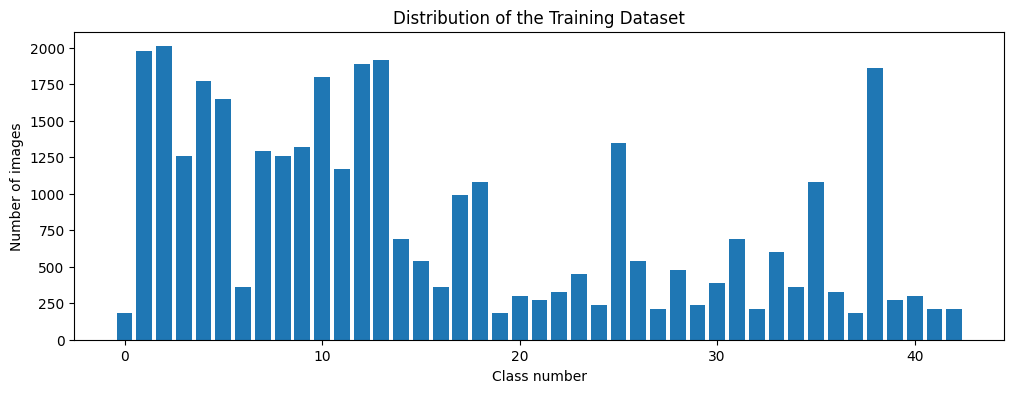

In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_classes = len(data)

num_of_samples = [np.sum(y_train == i) for i in range(num_classes)]

plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [9]:
# Preprocessing function
def image_preprocessor(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    return img / 255.0

# Apply preprocessing
X_train = np.array([image_preprocessor(img) for img in X_train])
X_val = np.array([image_preprocessor(img) for img in X_val])
X_test = np.array([image_preprocessor(img) for img in X_test])

In [10]:
# Reshape for PyTorch: (samples, 32, 32, 1)
X_train = X_train.reshape(-1, 32, 32, 1)
X_val = X_val.reshape(-1, 32, 32, 1)
X_test = X_test.reshape(-1, 32, 32, 1)

In [11]:
# Dataset class
class TrafficSignDataset(Dataset):
    def __init__(self, data, labels, transform=None):

        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert to PIL Image and apply transformations
        image = (self.data[idx] * 255).astype(np.uint8)  # Scale to [0, 255]
        image = Image.fromarray(image.squeeze(-1), 'L')  # Grayscale for PIL
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [12]:
# Define transformations without augmentation
transform_no_augmentation = transforms.Compose([
    transforms.ToTensor()
])

transform_augmentation = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=0.1, scale=(0.9, 1.1)),  # Rotation, width/height shift, shear, zoom
    transforms.ToTensor()
])

In [13]:
# Datasets and DataLoaders
train_dataset = TrafficSignDataset(X_train, y_train, transform=transform_augmentation)
val_dataset = TrafficSignDataset(X_val, y_val, transform=transform_no_augmentation)

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)


In [14]:
# Model Architecture
class SpatialPyramidPooling(nn.Module):
    def __init__(self, levels=[1, 2, 4]):
        super(SpatialPyramidPooling, self).__init__()
        self.levels = levels

    def forward(self, x):
        outputs = []
        n, c, h, w = x.size()
        for level in self.levels:
            kernel_size = (h // level, w // level)
            stride = kernel_size
            x_pooled = F.max_pool2d(x, kernel_size=kernel_size, stride=stride, padding=0)
            x_pooled = F.interpolate(x_pooled, size=(h, w), mode='bilinear', align_corners=False)
            outputs.append(x_pooled)
        return torch.cat(outputs, dim=1)  # Concatenating on the channel dimension

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class TrafficSignDetectionModel(nn.Module):
    def __init__(self):
        super(TrafficSignDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 120, kernel_size=1, padding='same')
        self.spp = SpatialPyramidPooling()
        self.conv2_path1 = nn.Conv2d(60, 60, kernel_size=3, padding='same')
        self.conv2_path2 = nn.Conv2d(180, 60, kernel_size=3, padding='same')
        self.conv3_path1 = nn.Conv2d(60, 60, kernel_size=1, padding='same')
        self.conv3_path2 = nn.Conv2d(60, 60, kernel_size=1, padding='same')
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(120 * 16 * 16, 500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 43)
        self.mish = Mish()

    def forward(self, x):
        x = self.mish(self.conv1(x))
        x1, x2 = x[:, :60], x[:, 60:]
        x2 = self.spp(x2)
        x1 = self.mish(self.conv2_path1(x1))
        x1 = self.mish(self.conv3_path1(x1))
        x2 = self.mish(self.conv2_path2(x2))
        x2 = self.mish(self.conv3_path2(x2))
        x = torch.cat([x1, x2], dim=1)
        x = self.max_pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        return self.fc2(x)

#Architecture is explained further in detail in the Term Paper

In [15]:
# Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficSignDetectionModel().to(device)
summary(model, input_size=(1,32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 120, 32, 32]             240
              Mish-2          [-1, 120, 32, 32]               0
SpatialPyramidPooling-3          [-1, 180, 32, 32]               0
            Conv2d-4           [-1, 60, 32, 32]          32,460
              Mish-5           [-1, 60, 32, 32]               0
            Conv2d-6           [-1, 60, 32, 32]           3,660
              Mish-7           [-1, 60, 32, 32]               0
            Conv2d-8           [-1, 60, 32, 32]          97,260
              Mish-9           [-1, 60, 32, 32]               0
           Conv2d-10           [-1, 60, 32, 32]           3,660
             Mish-11           [-1, 60, 32, 32]               0
        MaxPool2d-12          [-1, 120, 16, 16]               0
          Flatten-13                [-1, 30720]               0
           Linear-14                

## Either you can train the model using Option 1) or Load the Trained Model directly using Option 2)

### 1) Train the CSP Model

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    # Training
    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_correct = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
        train_acc = 100.0 * total_correct / len(train_loader.dataset)
        train_loss = total_train_loss / len(train_loader)

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
        val_acc = 100.0 * val_correct / len(val_loader.dataset)
        val_loss /= len(val_loader)

        # Store metrics for each epoch so that we can evaluate the performance
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")
        scheduler.step(val_loss)

    return history

history = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=20)


Epoch 1: Train Loss=2.3901, Train Acc=35.65%, Val Loss=1.1685, Val Acc=64.88%
Epoch 2: Train Loss=1.3116, Train Acc=59.74%, Val Loss=0.8703, Val Acc=72.43%
Epoch 3: Train Loss=1.0731, Train Acc=66.74%, Val Loss=0.7448, Val Acc=76.76%
Epoch 4: Train Loss=0.9151, Train Acc=71.76%, Val Loss=0.6061, Val Acc=80.39%
Epoch 5: Train Loss=0.7867, Train Acc=75.45%, Val Loss=0.5740, Val Acc=80.95%
Epoch 6: Train Loss=0.7056, Train Acc=77.97%, Val Loss=0.5123, Val Acc=83.88%
Epoch 7: Train Loss=0.6653, Train Acc=79.40%, Val Loss=0.4679, Val Acc=84.92%
Epoch 8: Train Loss=0.6246, Train Acc=81.06%, Val Loss=0.4679, Val Acc=85.06%
Epoch 9: Train Loss=0.5798, Train Acc=82.26%, Val Loss=0.4802, Val Acc=84.54%
Epoch 10: Train Loss=0.5692, Train Acc=82.49%, Val Loss=0.5139, Val Acc=84.85%
Epoch 11: Train Loss=0.5555, Train Acc=83.26%, Val Loss=0.4625, Val Acc=84.92%
Epoch 12: Train Loss=0.5230, Train Acc=84.24%, Val Loss=0.4096, Val Acc=86.55%
Epoch 13: Train Loss=0.5198, Train Acc=84.46%, Val Loss=0.363

In [17]:
# Using Google Drive(Recommended: To not Lose Previous work)
model_save_path = "/content/drive/My Drive/csp_traffic_sign_model.pth"  # Change this as needed and where you want to save the model on g-drive
history_save_path = "/content/drive/My Drive/csp_traffic_sign_history.pth"

In [18]:
# If you want to save it on Run time use(Simpler):
model_save_path = "/content/csp_traffic_sign_model.pth"
history_save_path = "/content/csp_traffic_sign_history.pth"

In [19]:
# Save the model parameters and history
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history
}, model_save_path)


### 2) Load the Model

In [ ]:
# if you are using Googel Drive(Recomended to not lose the file)
model_load_path = "/content/drive/My Drive/csp_traffic_sign_model.pth" #Change to where you have saved the model on drive if you saved it on runtime then change the path accordingly

In [22]:
# If you want to save on Run time use:
model_load_path = "/content/csp_traffic_sign_model.pth"

In [23]:
checkpoint = torch.load(model_load_path)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

history = checkpoint['history']

<ipython-input-23-fb9c3c9ff4f0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_load_path)


## Testing

In [24]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = 100.0 * total_correct / total_samples
    return accuracy

# Prepare the test DataLoader
test_dataset = TrafficSignDataset(X_test, y_test, transform=transform_no_augmentation)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)


test_accuracy = evaluate_accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 90.10%


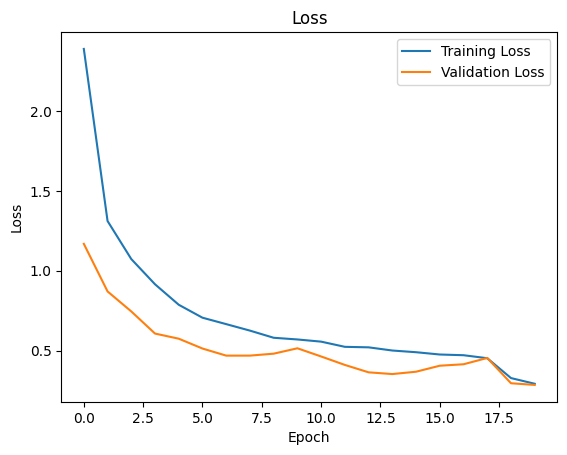

In [25]:
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

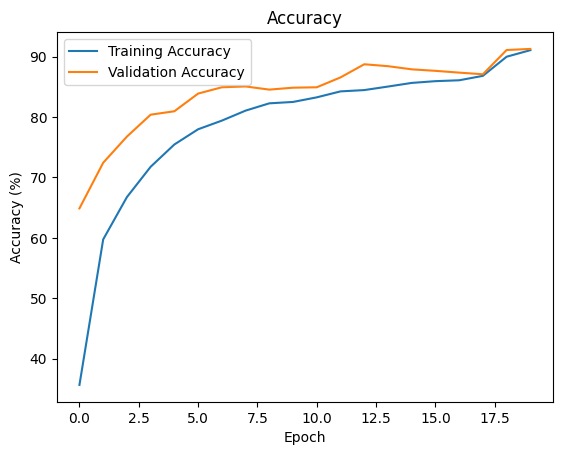

In [26]:
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

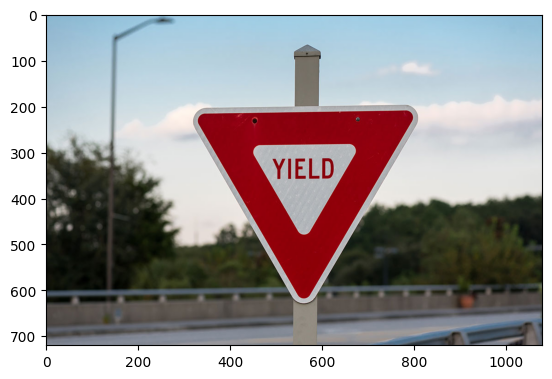

Predicted class number: 13, Sign: Yield


In [27]:
import requests
from PIL import Image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Load the image from the URL
url = 'https://mhmlegal.com/wp-content/uploads/2024/02/MHM-Blog-feb24-failure-to-yield.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img)
plt.show()

# Preprocess the image: resize, grayscale
image = np.array(img)
img = cv2.resize(image, (32, 32))  # Resize to match model input size
img = image_preprocessor(img)  # Apply preprocessing (grayscale, equalize, normalize)
img = img.reshape(1, 32, 32, 1)  # Add batch dimension and channel dimension

# Convert to PyTorch tensor and move to the device (e.g., GPU)
img_tensor = torch.tensor(img).permute(0, 3, 1, 2).float()  # Shape: (1, 1, 32, 32)
img_tensor = img_tensor.to(device)

# Model prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(img_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Map predicted class number to class name using 'data'
predicted_sign_name = data.iloc[predicted_class]['SignName']  # Get the sign name

print(f"Predicted class number: {predicted_class}, Sign: {predicted_sign_name}")


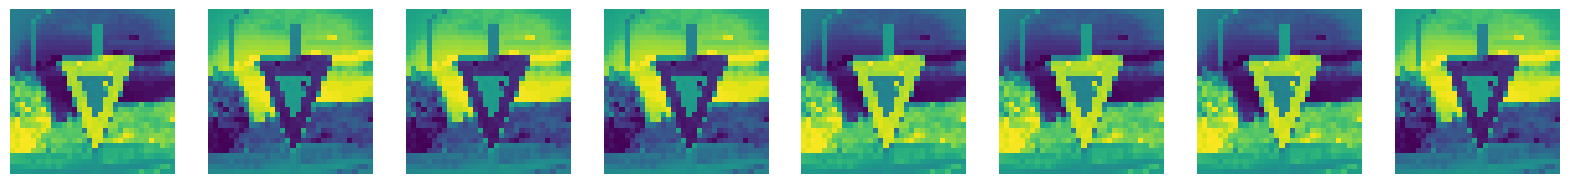

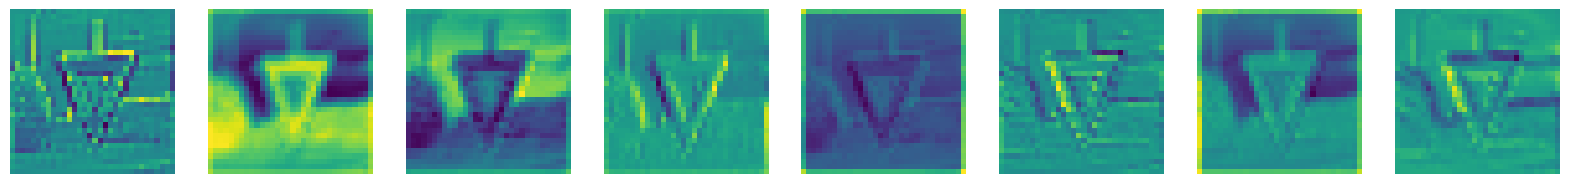

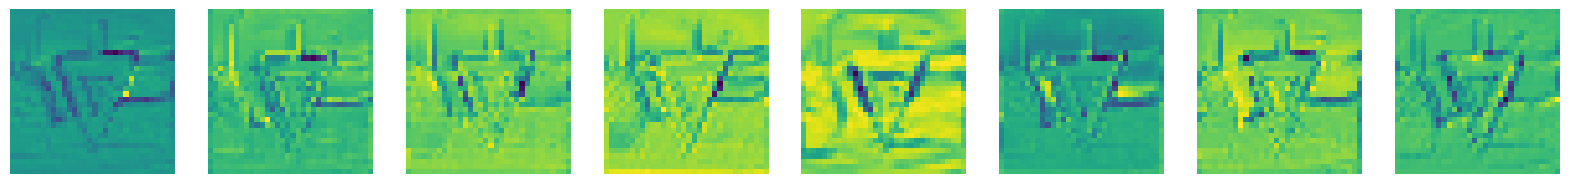

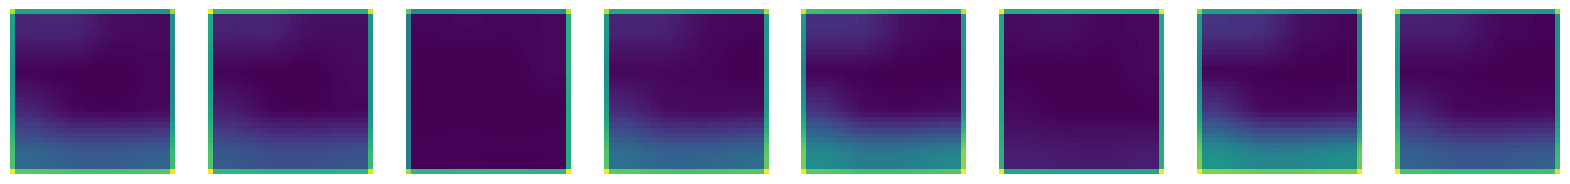

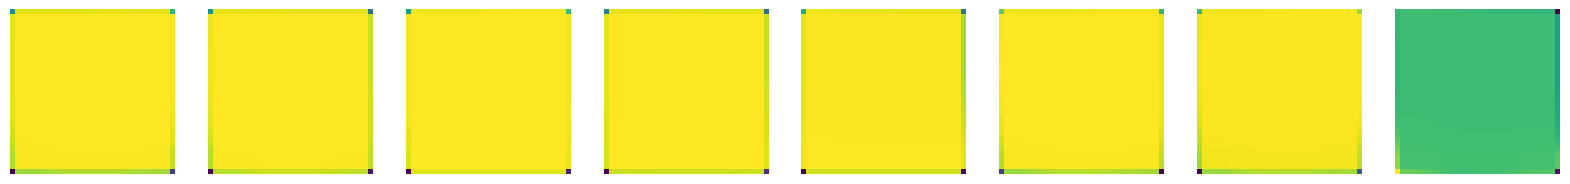

In [28]:
def visualize_feature_maps(model, input_image, device):

    model.eval()
    input_image = input_image.to(device)


    layer_outputs = []

    def hook_fn(module, input, output):
        layer_outputs.append(output)


    layers_to_hook = [
        model.conv1,
        model.conv2_path1,
        model.conv2_path2,
        model.conv3_path1,
        model.conv3_path2,
    ]
    hooks = [layer.register_forward_hook(hook_fn) for layer in layers_to_hook]

    # Forward pass through the model
    with torch.no_grad():
        _ = model(input_image)

    for hook in hooks:
        hook.remove()


    for i, layer_output in enumerate(layer_outputs):
        num_filters = layer_output.shape[1]
        fig, axes = plt.subplots(1, min(8, num_filters), figsize=(20, 5))


        for j in range(min(8, num_filters)):
            ax = axes[j]
            ax.imshow(layer_output[0, j].cpu(), cmap='viridis')
            ax.axis('off')

        plt.show()

input_image = img_tensor.squeeze()
input_image = input_image.unsqueeze(0).unsqueeze(0).to(device)

visualize_feature_maps(model, input_image, device)






### Detection and drawing Bounding boxes

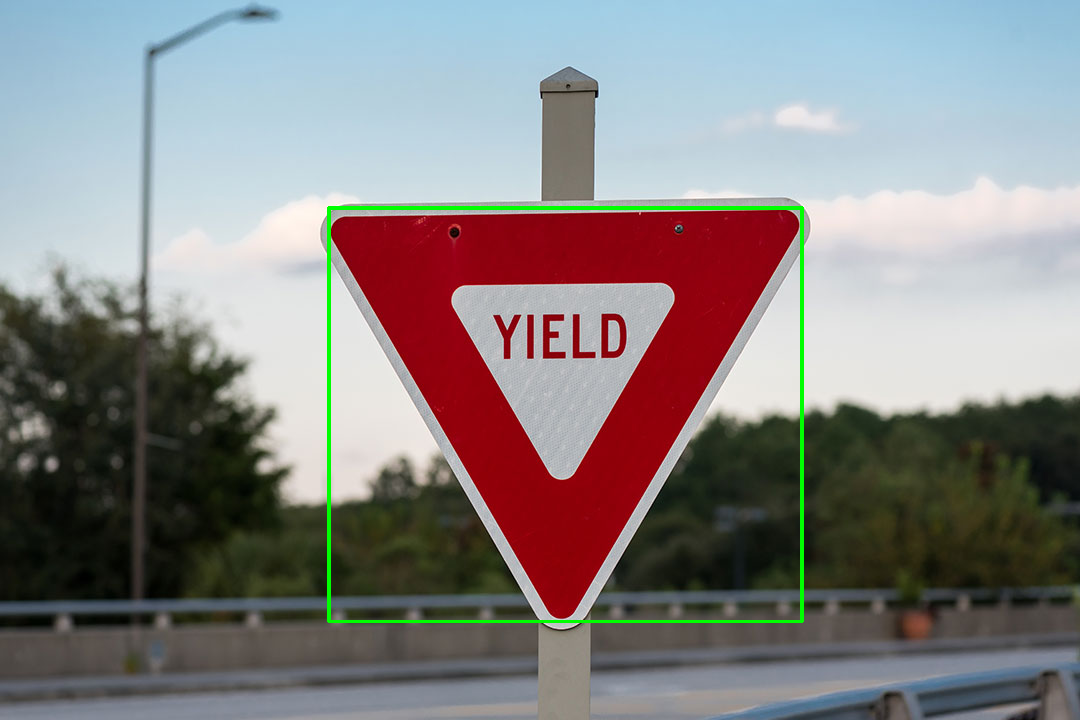

In [38]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def preprocess_image(image):
    try:
        img_hist_equalized = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        channels = list(cv2.split(img_hist_equalized))
        channels[0] = cv2.equalizeHist(channels[0])
        img_hist_equalized = cv2.merge(channels)
        img_hist_equalized = cv2.cvtColor(img_hist_equalized, cv2.COLOR_YCrCb2BGR)

        LoG_image = cv2.GaussianBlur(img_hist_equalized, (3, 3), 0)
        gray = cv2.cvtColor(LoG_image, cv2.COLOR_BGR2GRAY)
        LoG_image = cv2.Laplacian(gray, cv2.CV_8U, 3, 3, 2)
        LoG_image = cv2.convertScaleAbs(LoG_image)

        _, threshold_image = cv2.threshold(LoG_image, 32, 255, cv2.THRESH_BINARY)
        return threshold_image
    except Exception as e:
        print(f"Failed during preprocessing: {e}")
        return None

def filter_color(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color ranges
    lower_red = np.array([0, 50, 50])
    upper_red = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    lower_blue = np.array([100, 150, 0])
    upper_blue = np.array([140, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    combined_mask = cv2.bitwise_or(red_mask, blue_mask)
    combined_mask = cv2.bitwise_or(combined_mask, yellow_mask)

    filtered_image = cv2.bitwise_and(image, image, mask=combined_mask)
    return filtered_image

def find_contours(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def contour_is_sign(contour, threshold_circularity, threshold_triangle):
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return False

    area = cv2.contourArea(contour)
    circularity = 4 * np.pi * (area / (perimeter * perimeter))

    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    if len(approx) == 3 and area / cv2.contourArea(approx) > threshold_triangle:
        return True
    elif circularity > threshold_circularity:
        return True

    return False

def main():

    image_new = image
    if image_new is None:
        print("Error loading image. Please run the previous cell.")
        return

    filtered_image = filter_color(image_new)
    processed_image = preprocess_image(filtered_image)
    contours = find_contours(processed_image)
    min_area = 1000
    for contour in contours:
        if contour_is_sign(contour, 0.8, 0.9):
            x, y, w, h = cv2.boundingRect(contour)
            if w * h > min_area:
                cv2.rectangle(image_new, (x, y), (x + w, y + h), (0, 255, 0), 2)

    display_image = cv2.cvtColor(image_new, cv2.COLOR_BGR2RGB)
    cv2_imshow(display_image)

if __name__ == '__main__':
    main()


### Evaluating Computational Efficiency

In [33]:
model = TrafficSignDetectionModel().to('cpu')


input_res = (1, 32, 32)


with torch.cuda.device(0):
    macs, params = get_model_complexity_info(model, input_res, as_strings=True, print_per_layer_stat=False)

print(f'FLOPs: {macs}')
print(f'Parameters: {params}')


FLOPs: 156.57 MMac
Parameters: 15.52 M


In [36]:
#2) Measure Inference Time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()



num_runs = 100
start_time = time.time()
for _ in range(num_runs):
    with torch.no_grad():
        _ = model(img_tensor)
end_time = time.time()

average_inference_time = (end_time - start_time) / num_runs
print(f'Average Inference Time: {average_inference_time * 1000:.3f} ms')


Average Inference Time: 1.206 ms
